# Import

In [1]:
import os

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
#MNIST data image of shape 28*28=784
#mnist_size = 784
X = tf.placeholder(tf.float32, shape=[None, 784])
Z = tf.placeholder(tf.float32, shape=[None, 100])

# Set up parameters for generator and discriminator

In [3]:
# Generator
# Define the variables for the generator, we will use them to build layers later
# -------------------
size_g_w1 = 100
size_g_b1 = 128
# A good way to decide the std for initializing the weights
w1_std = 1.0/tf.sqrt(size_g_w1/2.0)

G_W1 = tf.Variable(tf.random_normal(shape=[size_g_w1, size_g_b1], stddev=w1_std))
G_b1 = tf.Variable(tf.zeros(shape=[size_g_b1]))

size_g_w2 = 128
size_g_b2 = 784
w2_std = 1.0/tf.sqrt(size_g_w2/2.0)

G_W2 = tf.Variable(tf.random_normal(shape=[size_g_w2, size_g_b2], stddev=w2_std))
G_b2 = tf.Variable(tf.zeros(shape=[size_g_b2]))
# theta_G and theta_D will be feeded to different optimizers later as "var_list", 
# since currently we have two networks instead of one now.
theta_G = [G_W1, G_W2, G_b1, G_b2]

# ====================
# Discriminator
# Define the variables for the discriminator
# --------------------
size_d_w1 = 784
size_d_b1 = 128
w1_std = 1.0/tf.sqrt(size_d_w1/2.0)

D_W1 = tf.Variable(tf.random_normal(shape=[size_d_w1,size_d_b1], stddev=w1_std))
D_b1 = tf.Variable(tf.zeros(shape=[size_d_b1]))

size_d_w2 = 128
size_d_b2 = 1
w2_std = 1.0/tf.sqrt(size_d_w2/2.0)

D_W2 = tf.Variable(tf.random_normal(shape=[size_d_w2,size_d_b2], stddev=w2_std))
D_b2 = tf.Variable(tf.zeros(shape=[size_d_b2]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Generator module

In [4]:
def generator(z):

    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_logit = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_logit)

    return G_prob, G_logit


# Discriminator module

In [5]:
def discriminator(x):

    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

# Generate samples function

In [6]:
def sample_z(m, n):
    # randomly generate samples for generator
    return np.random.uniform(-1.0, 1.0, size = [m, n])

# Plotting samples

In [7]:
def plot_sample(samples, size1, size2):
    
    fig1 = plt.figure(figsize=(size1, size2))
    gs = gridspec.GridSpec(size1, size2)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='gray')

    return fig1

# Faciliate the path defining process

In [8]:
# Though it's not possible to get the path to the notebook by __file__, os.path is still very useful in dealing with paths and files
# In this case, we can use an alternative: pathlib.Path
"""
code_dir   = os.path.dirname(__file__)
"""

code_dir = '/home/shayaan/Columbia/sem_1/Deep-Learning-for-OR-and-FE/assign4'

print code_dir
#create output_dir within the same path
output_dir = code_dir+'/outputGANs_test/'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

/home/shayaan/Columbia/sem_1/Deep-Learning-for-OR-and-FE/assign4


# Build GNN with defined vars and functions

In [9]:
# Put randomly generated sample Z into the generator to create "fake" images
G_sample, _ = generator(Z)
# The result of discriminator of real and fake samples
_, D_logit_real = discriminator(X)
_, D_logit_fake = discriminator(G_sample)

# generator loss 
# the goal of generator is to let discriminator make more mistakes on fake samples
# tf.ones_like returns a tensor with all elements set to 1
# 0 represent fake and 1 means real
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

# discriminator loss 
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)

# Start the session

In [10]:
def next_batch(data, batchSize):
    #Return a total of ‘batchSize‘ random samples
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batchSize]
    data_shuffle = np.array([data[i] for i in idx])
    return data_shuffle

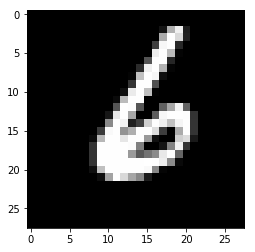

iteration: 0
D_loss: 2.095
G_loss: 1.213
()


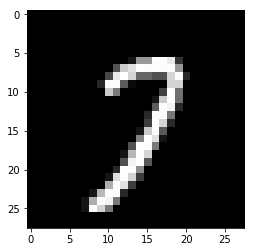

iteration: 1000
D_loss: 0.01216
G_loss: 7.642
()


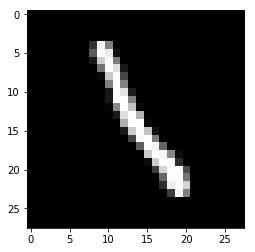

iteration: 2000
D_loss: 0.02329
G_loss: 6.237
()


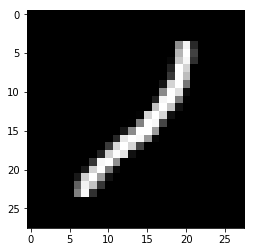

iteration: 3000
D_loss: 0.03526
G_loss: 4.806
()


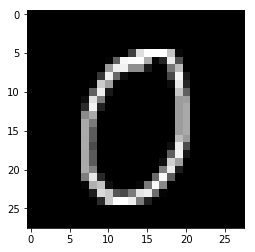

iteration: 4000
D_loss: 0.1473
G_loss: 5.143
()


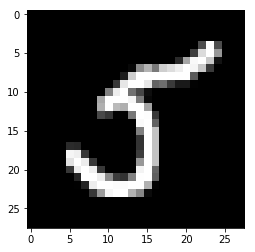

iteration: 5000
D_loss: 0.2223
G_loss: 5.999
()


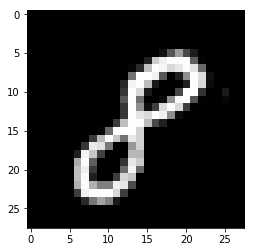

iteration: 6000
D_loss: 0.3273
G_loss: 5.473
()


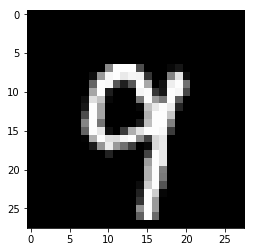

iteration: 7000
D_loss: 0.3751
G_loss: 3.553
()


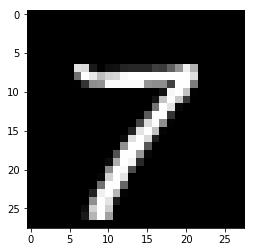

iteration: 8000
D_loss: 0.462
G_loss: 3.199
()


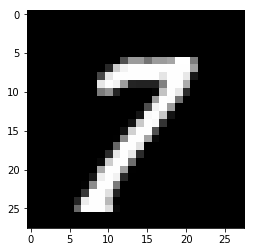

iteration: 9000
D_loss: 0.4008
G_loss: 3.082
()


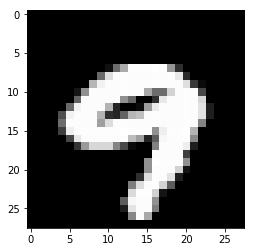

iteration: 10000
D_loss: 0.2876
G_loss: 3.831
()


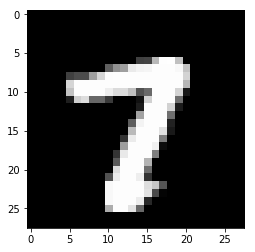

iteration: 11000
D_loss: 0.4628
G_loss: 2.861
()


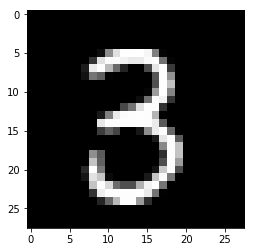

iteration: 12000
D_loss: 0.5257
G_loss: 3.206
()


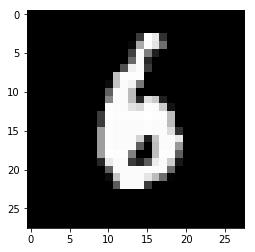

iteration: 13000
D_loss: 0.5237
G_loss: 2.3
()


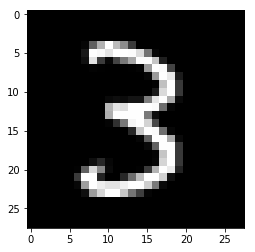

iteration: 14000
D_loss: 0.6677
G_loss: 2.622
()


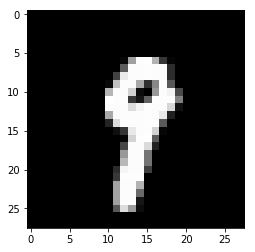

iteration: 15000
D_loss: 0.4089
G_loss: 2.655
()


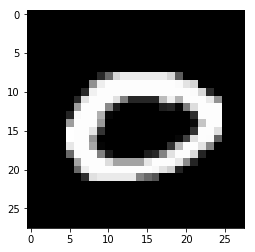

iteration: 16000
D_loss: 0.4142
G_loss: 2.462
()


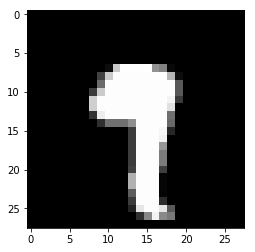

iteration: 17000
D_loss: 0.4981
G_loss: 2.505
()


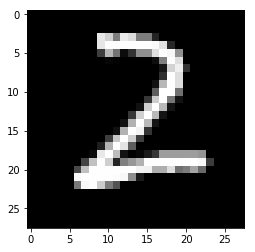

iteration: 18000
D_loss: 0.3651
G_loss: 2.699
()


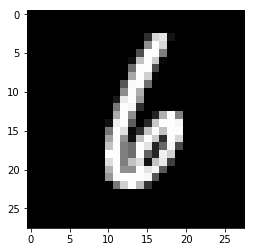

iteration: 19000
D_loss: 0.3774
G_loss: 2.743
()


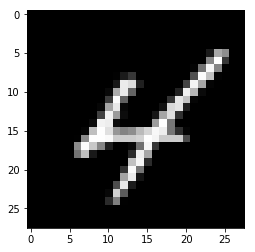

iteration: 20000
D_loss: 0.4348
G_loss: 2.765
()


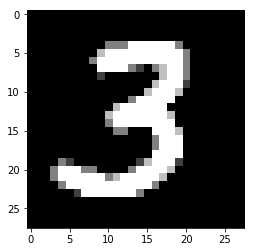

iteration: 21000
D_loss: 0.3098
G_loss: 2.995
()


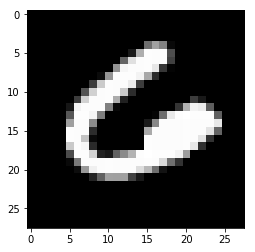

iteration: 22000
D_loss: 0.3743
G_loss: 2.889
()


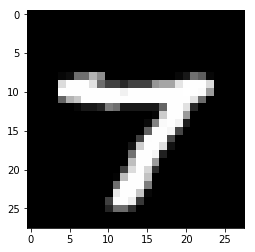

iteration: 23000
D_loss: 0.3167
G_loss: 2.961
()


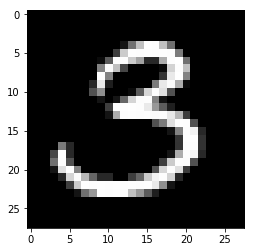

iteration: 24000
D_loss: 0.279
G_loss: 3.344
()


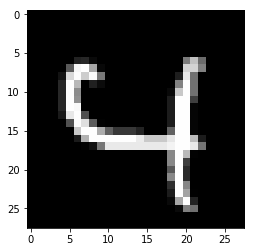

iteration: 25000
D_loss: 0.3869
G_loss: 2.936
()


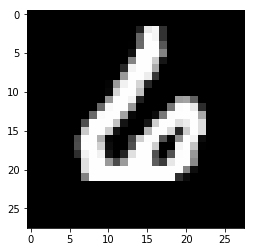

iteration: 26000
D_loss: 0.2614
G_loss: 3.472
()


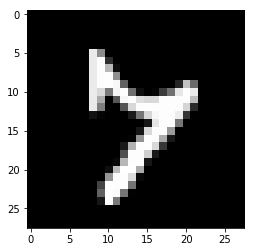

iteration: 27000
D_loss: 0.2095
G_loss: 3.343
()


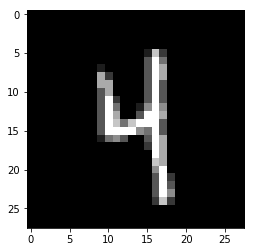

iteration: 28000
D_loss: 0.2199
G_loss: 3.11
()


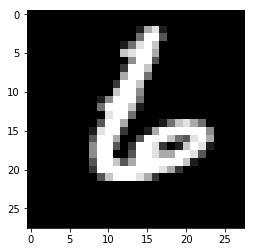

iteration: 29000
D_loss: 0.2134
G_loss: 2.529
()


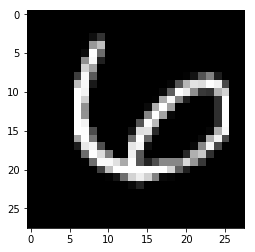

iteration: 30000
D_loss: 0.1998
G_loss: 3.52
()


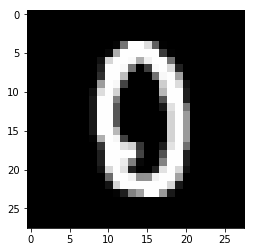

iteration: 31000
D_loss: 0.1746
G_loss: 3.363
()


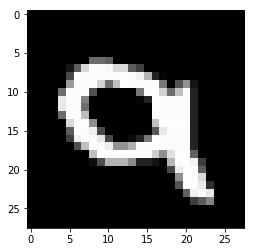

iteration: 32000
D_loss: 0.1986
G_loss: 3.045
()


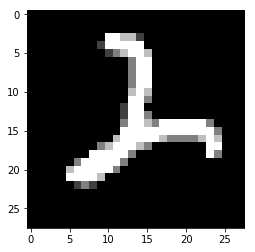

iteration: 33000
D_loss: 0.08659
G_loss: 3.047
()


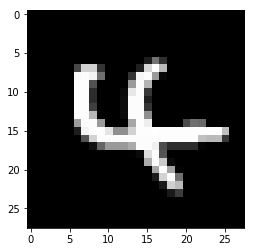

iteration: 34000
D_loss: 0.2652
G_loss: 2.926
()


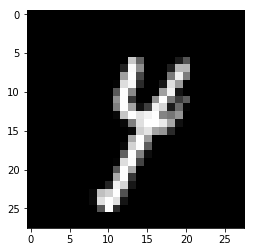

iteration: 35000
D_loss: 0.1266
G_loss: 3.277
()


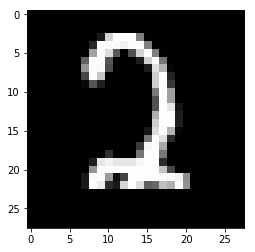

iteration: 36000
D_loss: 0.1523
G_loss: 3.676
()


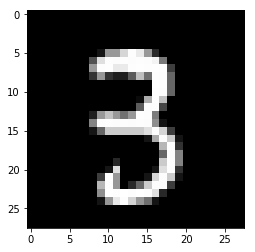

iteration: 37000
D_loss: 0.1661
G_loss: 3.532
()


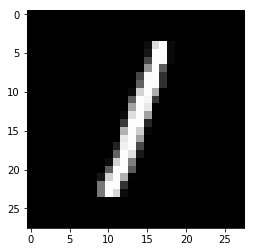

iteration: 38000
D_loss: 0.2684
G_loss: 4.725
()


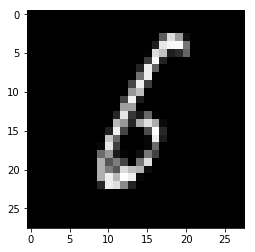

iteration: 39000
D_loss: 0.1911
G_loss: 4.984
()


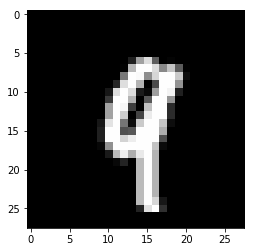

iteration: 40000
D_loss: 0.1187
G_loss: 3.643
()


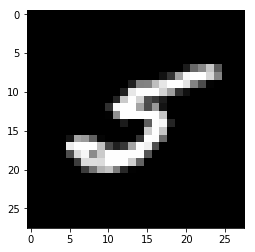

iteration: 41000
D_loss: 0.1194
G_loss: 3.515
()


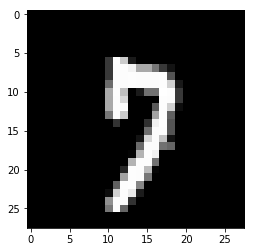

iteration: 42000
D_loss: 0.1056
G_loss: 3.915
()


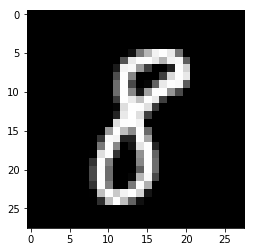

iteration: 43000
D_loss: 0.05959
G_loss: 4.538
()


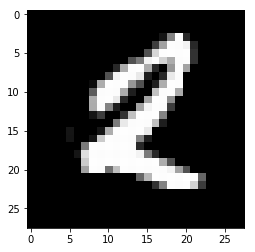

iteration: 44000
D_loss: 0.07434
G_loss: 3.826
()


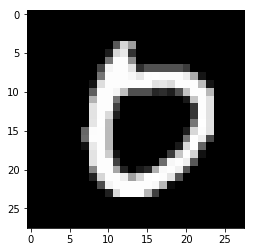

iteration: 45000
D_loss: 0.07465
G_loss: 3.777
()


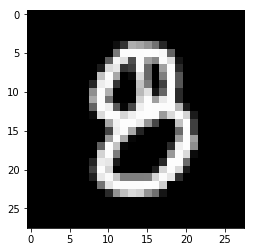

iteration: 46000
D_loss: 0.08054
G_loss: 4.04
()


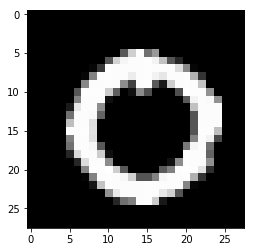

iteration: 47000
D_loss: 0.1356
G_loss: 4.349
()


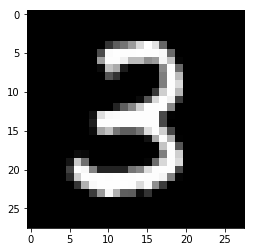

iteration: 48000
D_loss: 0.07682
G_loss: 4.642
()


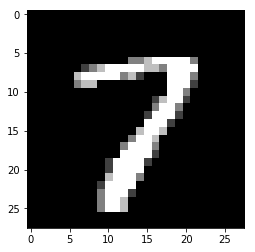

iteration: 49000
D_loss: 0.1081
G_loss: 4.6
()


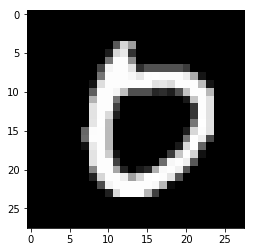

iteration: 50000
D_loss: 0.08501
G_loss: 4.09
()


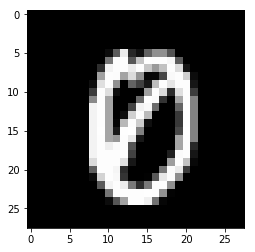

iteration: 51000
D_loss: 0.0967
G_loss: 4.723
()


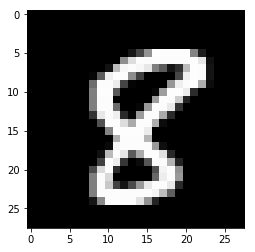

iteration: 52000
D_loss: 0.09203
G_loss: 4.6
()


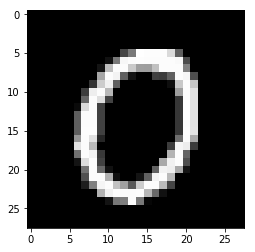

iteration: 53000
D_loss: 0.05588
G_loss: 5.12
()


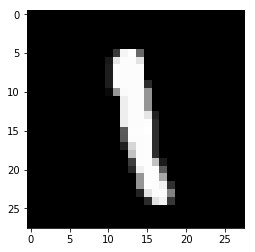

iteration: 54000
D_loss: 0.09069
G_loss: 5.284
()


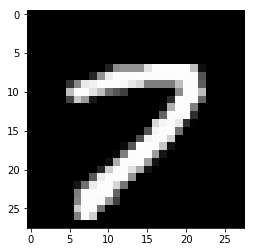

iteration: 55000
D_loss: 0.06149
G_loss: 5.301
()


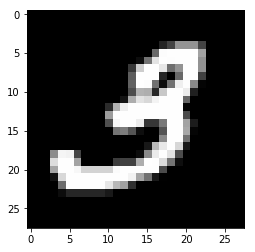

iteration: 56000
D_loss: 0.06605
G_loss: 5.128
()


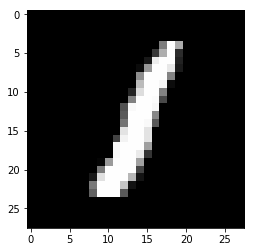

iteration: 57000
D_loss: 0.06494
G_loss: 4.588
()


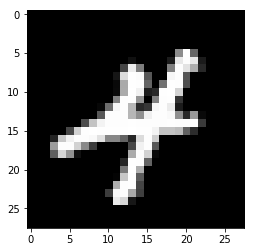

iteration: 58000
D_loss: 0.04359
G_loss: 4.869
()


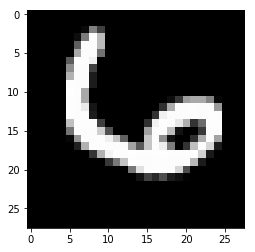

iteration: 59000
D_loss: 0.03843
G_loss: 5.245
()


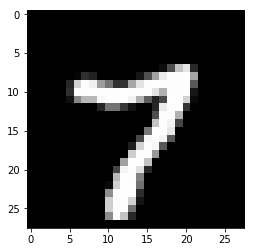

iteration: 60000
D_loss: 0.02112
G_loss: 5.902
()


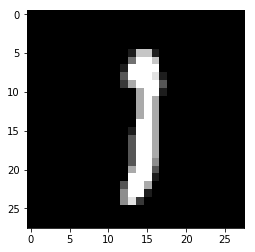

iteration: 61000
D_loss: 0.03445
G_loss: 5.642
()


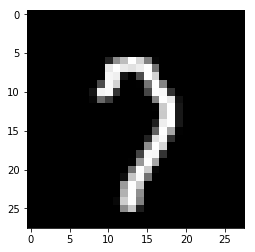

iteration: 62000
D_loss: 0.08032
G_loss: 5.244
()


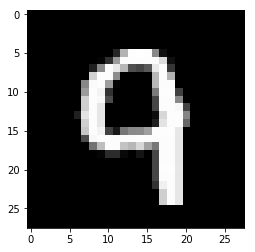

iteration: 63000
D_loss: 0.01165
G_loss: 6.293
()


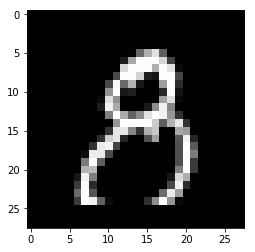

iteration: 64000
D_loss: 0.01365
G_loss: 5.748
()


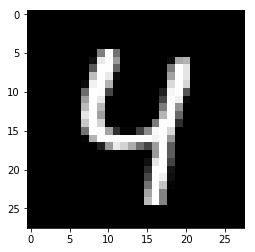

iteration: 65000
D_loss: 0.02909
G_loss: 5.407
()


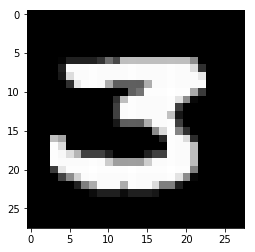

iteration: 66000
D_loss: 0.06924
G_loss: 6.117
()


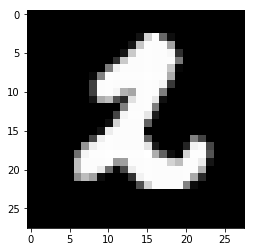

iteration: 67000
D_loss: 0.01615
G_loss: 6.303
()


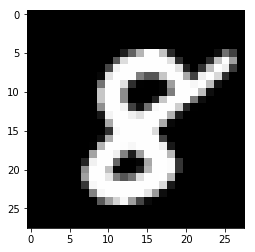

iteration: 68000
D_loss: 0.0462
G_loss: 7.042
()


KeyboardInterrupt: 

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 128
# the dimension of the random samples
z_dim = 100
result_freq = 1000
# plot generators' output every figure_iter step
figure_iter = 1000
max_iter = 100000
size1 = 5
size2 = 5
i = 0

for iter in range(max_iter):
    
    if iter % figure_iter == 0:
        
        # G_sample is a sample from the generator
        samples = sess.run(G_sample, feed_dict={Z: sample_z(size1*size2, z_dim)})

        fig1 = plot_sample(samples, size1, size2)
        plt.savefig(output_dir + 'GANs' + str(i) + '.png', bbox_inches='tight')
        i += 1
        plt.close(fig1)

    batch_xs = next_batch(mnist.train.images[:5000],batch_size)
    
    _, discriminator_loss = sess.run([D_solver, D_loss], feed_dict={X: batch_xs, Z: sample_z(batch_size, z_dim)})
    _, generator_loss     = sess.run([G_solver, G_loss], feed_dict={Z: sample_z(batch_size, z_dim)})

    if iter % result_freq == 0:
        first_image = batch_xs[0]
        first_image = np.array(first_image, dtype='float')
        pixels = first_image.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.show()
        print('iteration: {}'.format(iter))
        print('D_loss: {:0.4}'.format(discriminator_loss))
        print('G_loss: {:0.4}'.format(generator_loss))
        print()